# How to Train Your Neural Network

## Intro
A brief word on my background: I'm a particle physicist specializing in the top quark. The top quark is the most massive fundamental particle of the Standard Model (SM), with $m_{\rm{t}}=172.5\;\rm{GeV/c^2}$. This large mass gives the top quark some interesting properties which we'll explore later. These properties make it impossible to detect top quarks directly at the LHC. Therefore, we must rely on final-state decay particles. Many analyses perform statistical analysis purely on these final-state particles. Recently, there has been a lot if interest in reconstructing the top quark from these final states, particularly using machine learning (ML).

In this notebook I will explore some basic examples of using ML to reconstruct (toy) top quark events.

## Generating toy top quark events
I won't rely on the rather complex machinery of accurately producing and decaying top quarks, as well as simulating detector effects. We will instead simply generate some top quarks with random momenta as a quick example.

Make sure sci-kit help `vector` is installed

In [1]:
!pip install vector

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# allow plots in cell
%matplotlib inline

Import some standard libraries

In [3]:
import vector
import numpy as np
import pandas as pd

Define $m_\rm{t}$ and the number of events to generate

In [25]:
# Top quark mass in GeV
TOP_MASS = 172.5

# Number of events
n = 100_000

Function to generate top quarks

In [26]:
def generate_tops():
    # Random transverse momentum (pT) between 0 and 300 GeV
    pt = np.random.normal(0, 300, n)

    # Random pseudorapidity (eta) between -2.5 and 2.5
    eta = np.random.uniform(-2.5, 2.5, n)

    # Random azimuthal angle (phi) between -pi and pi
    phi = np.random.uniform(-np.pi, np.pi, n)

    # Calculate px, py, pz
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)

    # Calculate energy assuming top quark mass (using Einstein's special relativity)
    E = np.sqrt(px**2 + py**2 + pz**2 + TOP_MASS**2)

    # Build Lorentz vectors
    tops = vector.arr({
        "px": px,
        "py": py,
        "pz": pz,
        "E": E,
    })
    
    return tops

Function to save top quarks in a `parquet` file

In [27]:
def save_tops():
    df = pd.DataFrame({
        "top_px": tops.px,
        "top_py": tops.py,
        "top_pz": tops.pz,
        "top_energy": tops.E,
        "top_pt": tops.pt,
        "top_eta": tops.eta,
        "top_phi": tops.phi,
        "top_mass": tops.mass,
    })

    # Save to Parquet
    df.to_parquet("top_quarks.parquet")

Let's actually make the top quarks and print the first entry

In [28]:
tops = generate_tops()
# Example: print the first one
print(tops[0])
save_tops()

MomentumObject4D(px=153.33193262164215, py=98.47592411720272, pz=304.9325400304983, E=394.9028907993411)


## Training a DNN
Now that we have a thousand top quarks to play with, let's explore training a neural network.
In this first example we _only_ have the top quarks, no decay particles and no detector smearing. This reduces down to a case for simple linear regression. However, I will still use the full machinery for a DNN to demonstrate the basic setup and show that we indeed get back a linear fit.

First we'll load the necessary `pytorch` librarires

In [8]:
import torch
import os
import gc
#import tracemalloc
from torch.utils.data import DataLoader
import numpy as np 
import pandas as pd
from tqdm import tqdm
from torch import optim
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
#from analysis.ttbarML.options import handleOptions
from options import handleOptions
#from utils.options import handleOptions
#from analysis.ttbarML.metrics import net_eval
from metrics import net_eval
#from utils.metrics import net_eval
import torch.nn as nn

from torch.profiler import profile, record_function, ProfilerActivity

Next we'll define some plotting functions that we'll use while training

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!pip install tqdm
#!pip install "coffea==0.7.22"
#!pip install "numpy>=1.22"
%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [10]:
#from sklearn.metrics import roc_curve

def save_and_plot(net, loss_test, loss_train, label, test_input, test_feat, feature_division, norm_test, norm_targ, show=False):
    '''
    creates a directory with the label name and saves the network, the loss plot, the network output plot, the ROC curve and the performance metrics
        net: neural network
        loss_test: loss on the test dataset
        loss_train: loss on the training dataset
        label: name of the directory
        bsm_name: name of the BSM term
        test: test dataset
    '''
    try:
        os.mkdir(f'ml_out')
    except:
        pass
    try:
        os.mkdir(f'ml_out/{label}')
    except:
        pass
    torch.save(net, f'ml_out/{label}/network.p')
    torch.save(net.state_dict(), f'ml_out/{label}/network_state_dict.p')
    fig, ax = plt.subplots(1, 1, figsize=[8,8])
    
    ax.plot( range(len(loss_test)), loss_train, label="Training dataset")
    ax.plot( range(len(loss_test)), loss_test , label="Testing dataset")
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/loss.png')
    ax.set_yscale('log')
    fig.savefig(f'ml_out/{label}/loss_log.png')
    plt.clf()
    
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    
    #print(f'Input values {test_input=}')
    #print(f'Expected values {test_feat=}')
    #print(f'Output values {net(test_feat)=}')
    #print(test[0].detach().cpu().numpy(), net(test[:]).ravel().detach().cpu().numpy())
    #sm_hist,bins,_  = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
    #print('plotting features', test_feat.detach().cpu().numpy()[0])
    #print('plotting features', test_feat[:,0].detach().cpu().numpy()[0])
    #print('plotting inputs',   test_input[:,0].detach().cpu().numpy()[0])
    #print('plotting inputs',   test_input[0].detach().cpu().numpy()[0])
    #print('plotting outputs',  net(test_input).detach().cpu().numpy()[:,0][0])
    #print('plotting outputs',  net(test_input).detach().cpu().numpy())
    #print(net(test_input[0]).shape)
    #print('plotting predictions', net(test_input[0]).detach().cpu().numpy())
    #print('Plotting x,y', test_feat[0].detach().cpu().numpy()*norm_targ[0].detach().cpu().numpy(), net(test).ravel().detach().cpu().numpy()*norm_test.detach().cpu().numpy()[0])
    #print('Plotting x,y', test_feat[0].detach().cpu().numpy()*norm_targ[0].detach().cpu().numpy(), net(test).ravel().detach().cpu().numpy()[::feature_division]*norm_test.detach().cpu().numpy()[0])
    #print(len(test_feat[:,0].detach().cpu().numpy()*norm_targ[0].detach().cpu().numpy()), len(net(test).ravel().detach().cpu().numpy()[:,0]*norm_test.detach().cpu().numpy()[0]))
    #print(test_feat.shape)
    #for i in range(min(10, test_feat.shape[0])):
    #for i in range(test_feat.shape[0]):
        #sm_hist  = ax.scatter(test_feat[i].detach().cpu().numpy()[0]*norm_targ[0].detach().cpu().numpy()[0], net(test_input[i]).detach().cpu().numpy()[0]*norm_test.detach().cpu().numpy()[0][0],
        #print(f'Plotting {i} {test_feat[i].detach().cpu().numpy(), net(test_input[i]).detach().cpu().numpy()}')
        #sm_hist  = ax.scatter(test_feat[i].detach().cpu().numpy(), net(test_input[i]).detach().cpu().numpy(),
    bins = np.linspace(-10, 10, 100)
    #sm_hist  = ax.scatter(test[0][0].detach().cpu().numpy(), net(test[0][3:]).ravel().detach().cpu().numpy()[0],
    #sm_hist,bins,_  = ax.scatter(test[0][0].detach().cpu().numpy(), net(test[0][3:]).ravel().detach().cpu().numpy()[0],
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           #alpha=0.5, label='SM')
                           #bins=100, alpha=0.5, label='SM', density=True)
    sm_hist  = ax.scatter(test_feat.cpu().numpy()[:,0], net(test_input).detach().cpu().numpy()[:,0],
                          alpha=0.5, label='px')
    sm_hist  = ax.scatter(test_feat.cpu().numpy()[:,1], net(test_input).detach().cpu().numpy()[:,1],
                          alpha=0.5, label='py')
    sm_hist  = ax.scatter(test_feat.cpu().numpy()[:,2], net(test_input).detach().cpu().numpy()[:,2],
                          alpha=0.5, label='pz')
    sm_hist  = ax.scatter(test_feat.cpu().numpy()[:,3], net(test_input).detach().cpu().numpy()[:,3],
                          alpha=0.5, label='e')
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    bins = np.linspace(-0.5, 0.5, 10)
    vals = test_feat.detach().cpu().numpy()[:,0]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,0], net(test_input).detach().cpu().numpy()[:,0],
    #sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,0], net(test_input).detach().cpu().numpy()[:,0],
                          alpha=0.5, label='px')#, bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_px.png')
    plt.clf()
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    vals = test_feat.detach().cpu().numpy()[:,1]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,1], net(test_input).detach().cpu().numpy()[:,1],
    #sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,1], net(test_input).detach().cpu().numpy()[:,1],
                          alpha=0.5, label='py')#, bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_py.png')
    plt.clf()
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    vals = test_feat.detach().cpu().numpy()[:,2]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,2], net(test_input).detach().cpu().numpy()[:,2],
    #sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,2], net(test_input).detach().cpu().numpy()[:,2],
                          alpha=0.5, label='pz')#, bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    #plt.xlim(-0.5,0.5)
    #plt.ylim(-0.5,0.5)
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_pz.png')
    plt.clf()
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    vals = test_feat.detach().cpu().numpy()[:,3]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,3], net(test_input).detach().cpu().numpy()[:,3],
    #sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,3], net(test_input).detach().cpu().numpy()[:,3],
                          alpha=0.5, label='e')#, bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_energy.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    bins = np.linspace(-1, 1, 10)
    vals = test_feat.detach().cpu().numpy()[:,0]
    pred = net(test_input).detach().cpu().numpy()[:,0]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    #sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,0], net(test_input).detach().cpu().numpy()[:,0],
    sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,0], net(test_input).detach().cpu().numpy()[:,0],
                          alpha=0.5, label='px', bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    #plt.xlim(-0.5,0.5)
    #plt.ylim(-0.5,0.5)
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    #if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_px2d.png')
    plt.clf()
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    vals = test_feat.detach().cpu().numpy()[:,1]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    #sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,1], net(test_input).detach().cpu().numpy()[:,1],
    sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,1], net(test_input).detach().cpu().numpy()[:,1],
                          alpha=0.5, label='py', bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_py2d.png')
    plt.clf()
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    vals = test_feat.detach().cpu().numpy()[:,2]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    #sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,2], net(test_input).detach().cpu().numpy()[:,2],
    sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,2], net(test_input).detach().cpu().numpy()[:,2],
                          alpha=0.5, label='pz', bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    #plt.xlim(-0.5,0.5)
    #plt.ylim(-0.5,0.5)
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_pz2d.png')
    plt.clf()
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    vals = test_feat.detach().cpu().numpy()[:,3]
    bins = np.linspace(np.min(np.mean(vals) - 2*np.std(vals)), np.max(np.mean(vals) + 2*np.std(vals)), 100)
    bins = np.array([bins, bins])
    #sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,3], net(test_input).detach().cpu().numpy()[:,3],
    sm_hist  = ax.hist2d(test_feat.detach().cpu().numpy()[:,3], net(test_input).detach().cpu().numpy()[:,3],
                          alpha=0.5, label='e', bins=bins)
    '''
    bsm_hist,_,_ = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           bins=bins, alpha=0.5, label='BSM', density=True)
    '''
    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_out_energy2d.png')
    plt.clf()
    
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    
    res = net(test_input).detach().cpu().numpy()[:,0] - test_feat.detach().cpu().numpy()[:,0]
    res_bins = np.linspace(np.min(res), np.max(res), 50)
    res_bins = np.linspace(-5, 5, 50)
    #for i in range(min(10, test_feat.shape[0])):
        #sm_hist  = ax.hist(test_feat[i].detach().cpu().numpy()[0]*norm_targ[0].detach().cpu().numpy()[0] - net(test_input[i]).detach().cpu().numpy()[0]*norm_test.detach().cpu().numpy()[0][0],
        #sm_hist  = ax.hist(test_feat[i].detach().cpu().numpy()[0] - net(test_input[i]).detach().cpu().numpy()[0],
        #                    bins=res_bins, alpha=0.5, label='SM')
        #print(i, test_feat[i].detach().cpu().numpy()[0] - net(test_input[i]).detach().cpu().numpy()[0])
        #print(i,
        #      f"{test_feat.detach().cpu().numpy()[:,0]=}",
        #      f"{test_feat[0].detach().cpu().numpy()[0]=}",#*norm_targ[0].detach().cpu().numpy()[0]=}",
        #      f"{net(test_input[i]).detach().cpu().numpy()[0]=}",#*norm_test.detach().cpu().numpy()[0][0]=}",
        #      f"{test_feat[i].detach().cpu().numpy()[0]*norm_targ[0].detach().cpu().numpy()[0] - net(test_input[i]).detach().cpu().numpy()[0]*norm_test.detach().cpu().numpy()[0][0]=}")
    #print(test_feat.detach().cpu().numpy()[:,0] - net(test_input).detach().cpu().numpy()[:,0])
    #print(np.mean(test_feat.detach().cpu().numpy()[:,0] - net(test_input).detach().cpu().numpy()[:,0]))
    #print(np.std(test_feat.detach().cpu().numpy()[:,0] - net(test_input).detach().cpu().numpy()[:,0]))
    #sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,0] - net(test_input).detach().cpu().numpy()[:,0],
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy() - net(test_input).detach().cpu().numpy(),
                        bins=res_bins, alpha=0.5, label=['px','py','pz','e'])
    ax.set_xlabel('Residual', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/net_res.png')
    plt.clf()
    
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,0] / test_feat.detach().cpu().numpy()[:,0]
    res_bins = np.linspace(np.min(res), np.max(res), 50)
    res_bins = np.linspace(-5, 5, 50)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,0],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,0],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('px', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/comp_x.png')
    plt.clf()
    
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,1]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    targ = net(test_input).detach().cpu().numpy()[:,3]
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,1],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,1],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('py', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/comp_y.png')
    plt.clf()
    
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,2]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,2],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,2],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('pz', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/comp_z.png')
    plt.clf()
    
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,3]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,3],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,3],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('energy', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/comp_energy.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,0]
    targ = test_feat.detach().cpu().numpy()[:,0]
    bins = np.linspace(-.1, .1, 100)
    ypred,_ = np.histogram(res, bins)
    ytrue,_ = np.histogram(targ, bins)
    norm_binned = [np.mean((res-targ)[np.where((targ > low) & (targ <= high))]) for low, high in zip(bins[:-1], bins[1:])]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.scatter(bins[:-1], norm_binned,
                       alpha=0.5)
    ax.set_xlabel('true px', fontsize=12)
    ax.set_ylabel('$\\langle pred px - true px \\rangle$', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/bias_px.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,1]
    targ = test_feat.detach().cpu().numpy()[:,1]
    bins = np.linspace(-.1, .1, 100)
    ypred,_ = np.histogram(res, bins)
    ytrue,_ = np.histogram(targ, bins)
    norm_binned = [np.mean((res-targ)[np.where((targ > low) & (targ <= high))]) for low, high in zip(bins[:-1], bins[1:])]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.scatter(bins[:-1], norm_binned,
                       alpha=0.5)
    ax.set_xlabel('true py', fontsize=12)
    ax.set_ylabel('$\\langle pred py - true py \\rangle$', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/bias_py.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,2]
    targ = test_feat.detach().cpu().numpy()[:,2]
    bins = np.linspace(-.1, .1, 100)
    ypred,_ = np.histogram(res, bins)
    ytrue,_ = np.histogram(targ, bins)
    norm_binned = [np.mean((res-targ)[np.where((targ > low) & (targ <= high))]) for low, high in zip(bins[:-1], bins[1:])]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.scatter(bins[:-1], norm_binned,
                       alpha=0.5)
    ax.set_xlabel('true pz', fontsize=12)
    ax.set_ylabel('$\\langle pred pz - true pz \\rangle$', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/bias_pz.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,3]
    targ = test_feat.detach().cpu().numpy()[:,3]
    bins = np.linspace(-.1, .1, 100)
    ypred,_ = np.histogram(res, bins)
    ytrue,_ = np.histogram(targ, bins)
    norm_binned = [np.mean((res-targ)[np.where((targ > low) & (targ <= high))]) for low, high in zip(bins[:-1], bins[1:])]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.scatter(bins[:-1], norm_binned,
                       alpha=0.5)
    ax.set_xlabel('true energy', fontsize=12)
    ax.set_ylabel('$\\langle pred energy - true energy \\rangle$', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/bias_energy.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,0]
    targ = test_feat.detach().cpu().numpy()[:,0]
    bins = np.linspace(-1, 1, 100)
    ypred,_ = np.histogram(res, bins)
    ytrue,_ = np.histogram(targ, bins)
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(1 - np.square(ypred - ytrue) / np.square(ypred - np.mean(ytrue)),
                       bins=bins, alpha=0.5)
    ax.set_xlabel('R px', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/R_px.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,0]
    targ = test_feat.detach().cpu().numpy()[:,0]
    sm_hist  = ax.hist(np.power(res - targ, 2),
                       bins=np.linspace(0, 1, 100), alpha=0.5, label='MSE px')
    ax.set_xlabel('MSE px', fontsize=12)
    #ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/mse_px.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,1]
    targ = test_feat.detach().cpu().numpy()[:,1]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(np.power(res - targ, 2),
                       bins=np.linspace(0, 1, 100), alpha=0.5, label='MSE py')
    ax.set_xlabel('MSE px', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/mse_py.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,2]
    targ = test_feat.detach().cpu().numpy()[:,2]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(np.power(res - targ, 2),
                       bins=np.linspace(0, 1, 100), alpha=0.5, label='MSE pz')
    ax.set_xlabel('MSE px', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/mse_pz.png')
    plt.clf()

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res  = net(test_input).detach().cpu().numpy()[:,3]
    targ = test_feat.detach().cpu().numpy()[:,3]
    #res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(np.power(res - targ, 2),
                       bins=np.linspace(0, 1, 100), alpha=0.5, label='MSE energy')
    ax.set_xlabel('MSE energy', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'ml_out/{label}/mse_energy.png')
    plt.clf()

    plt.close()

'''
    fpr, tpr, _ = roc_curve(test_feat.squeeze(-1).detach().cpu().numpy()[:,0], net(test_input).squeeze(-1).detach().cpu().numpy()[:,0]) 
    plt.plot(fpr, tpr, marker='.')

    #roc, auc, a = net_eval(net(test[:]), test[:], test[:])
    roc, auc = net_eval(net(test_input).detach().cpu(), test_feat.detach().cpu(), test_input.detach().cpu())
    
    fig, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.plot(roc[:,0], roc[:,1], label='Network Performance')
    ax.plot([0,1],[0,1], ':', label='Baseline')
    ax.legend()
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    fig.savefig(f'ml_out/{label}/ROC.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.plot(roc[:,0], roc[:,1], label='Network Performance')
    ax.plot([0,1],[0,1], ':', label='Baseline')
    ax.legend()
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.savefig(f'ml_out/{label}/ROC_log.png')
    plt.clf()
    
    plt.close()
    auc = auc.data.cpu().numpy()
    a   = a.data.cpu().numpy()
    
    f = open(f'{label}/performance.txt','w+')
    f.write(f'Area under ROC: {auc}\nAccuracy:       {a}\n')
    f.close()
    '''

"\n    fpr, tpr, _ = roc_curve(test_feat.squeeze(-1).detach().cpu().numpy()[:,0], net(test_input).squeeze(-1).detach().cpu().numpy()[:,0]) \n    plt.plot(fpr, tpr, marker='.')\n\n    #roc, auc, a = net_eval(net(test[:]), test[:], test[:])\n    roc, auc = net_eval(net(test_input).detach().cpu(), test_feat.detach().cpu(), test_input.detach().cpu())\n    \n    fig, ax = plt.subplots(1, 1, figsize=[8,8])\n    ax.plot(roc[:,0], roc[:,1], label='Network Performance')\n    ax.plot([0,1],[0,1], ':', label='Baseline')\n    ax.legend()\n    ax.set_xlabel('False Positive Rate', fontsize=14)\n    ax.set_ylabel('True Positive Rate', fontsize=14)\n    fig.savefig(f'ml_out/{label}/ROC.png')\n    plt.clf()\n    \n    fig, ax = plt.subplots(1, 1, figsize=[8,8])\n    ax.plot(roc[:,0], roc[:,1], label='Network Performance')\n    ax.plot([0,1],[0,1], ':', label='Baseline')\n    ax.legend()\n    ax.set_xlabel('False Positive Rate', fontsize=14)\n    ax.set_ylabel('True Positive Rate', fontsize=14)\n    ax.

Next we'll define an activation hook that we can use to monitor the training

In [11]:
# Register hooks for all ReLU layers
activations = []

def activation_hook(module, input, output):
    activations.append(output)

And finally we'll define the `main` function that will perform out fitting

In [ ]:
def main(features = 'top_x,top_y,top_z,top_energy,top_x,top_y,top_z,top_energy', 
         feature_division = 4, 
         forceRebuild = True,
         files = "top_quarks.parquet"):
    torch.manual_seed(42)
    #args = handleOptions()
    arg = {}
    #parser.add_argument("--reload",  action='store_true', default=False, help="Force conversion of hdf to pytorch")
    #files = "NAOD*"#"-00000_1016.root"
    #files = "top_quark_reco_events.root"
    #files = "NAOD-00000_1016.root"
    device = 'cuda'
    name = ''
    out_path = '.'
    #features = "ttbar_pt, ttbar_eta, ttbar_phi, ttbar_pz, ttbar_mass, ttbar_energy, Lep1_pt,Lep2_pt,Lep1_eta,Lep2_eta,Lep2_phi,Lep2_phi,Jet1_pt,Jet1_eta,Jet1_phi,Jet2_pt,Jet2_eta,Jet2_phi,Jet3_pt,Jet3_eta,Jet3_phi,Jet4_pt,Jet4_eta,Jet4_phi,met_pt,PT_pt"
    #features = "top1_pt,lep1_pt"
    #input_features = "top1_pt"
    #input_nodes = "lepton1_pt,lepton1_eta,lepton1_phi,lepton2_pt,lepton2_eta,lepton2_phi"
    #features = ','.join([input_features, input_nodes])
    #features = "ttbar_x, ttbar_y, ttbar_z, Lep1_x,Lep2_x,Lep1_y,Lep2_y,Lep2_z,Lep2_z,Jet1_x,Jet1_y,Jet1_z,Jet2_x,Jet2_y,Jet2_z,Jet3_x,Jet3_y,Jet3_z,Jet4_x,Jet4_y,Jet4_z,met_x"
    #features = 'top_x,top_y,top_z,top_energy,top_x,top_y,top_z,top_energy'
    #feature_division = len(input_features.split(","))
    batch_size = 64
    epochs = 20
    learning_rate = 0.05
    factor = 0.01
    patience = 10
    norm = True
    cores = 1
    arg['files'] = files
    arg['device'] = device
    arg['name'] = name
    arg['out_path'] = out_path
    arg['features'] = features
    arg['feature_division'] = feature_division
    arg['forceRebuild'] = forceRebuild
    arg['batch_size'] = batch_size
    arg['epochs'] = epochs
    arg['learning_rate'] = learning_rate
    arg['factor'] = factor
    arg['patience'] = patience
    arg['norm'] = norm
    arg['profile'] = profile
    arg['cores'] = cores
    arg['plots'] = True

    # Now we decide how (if) we will use the gpu
    if device != 'cpu' and not torch.cuda.is_available():
        print("Warning, you tried to use cuda, but its not available. Will use the CPU")
        device = 'cpu'
        arg['device'] = 'cpu'
    print(f'{device=}')

    # If we use the cpu we dont use the whole UI (at psi)
    torch.set_num_threads(arg['cores'])#8)

    # all the stuff below should be configurable in the future
    # we get the model = net + cost function
    #from analysis.ttbarML.net import Model
    from net import Model#, MomentumGNN
    #from models.net import Model
    print(features.split(','))
    print('Fitting:', features.split(',')[feature_division:])
    model = Model(features = len(features.split(",")), feature_division = feature_division, device = device)
    #model = Model(features = 8, feature_division = feature_division, device = device)
 
    # Register hooks for all ReLU layers
    for layer in model.net.modules():
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU):
            layer.register_forward_hook(activation_hook)

    # now we get the data
    #from analysis.ttbarML.data import eftDataLoader
    from data import eftDataLoader
    signal_dataset = eftDataLoader( arg )
    #sm_mean = torch.mean(signal_dataset.sm_weight); bsm_mean = torch.mean(signal_dataset.bsm_weight)
    mean = torch.mean(signal_dataset.features)
    dataset_size = len(signal_dataset)
    train_size = int(0.7 * dataset_size)
    train, test    = torch.utils.data.random_split( signal_dataset, [train_size, (dataset_size-train_size)], generator=torch.Generator().manual_seed(42))
    train, test    = torch.utils.data.random_split( signal_dataset, [train_size, (dataset_size-train_size)], generator=torch.Generator().manual_seed(0))
    #dataloader     = DataLoader(  train  , batch_size=arg['batch_size'], shuffle=True)

    #normalize features
    mu,std = torch.mean(train[:]), torch.std(train[:])
    norm_train_targ, norm_train = train[:][:,:feature_division].norm(p=2, dim=1, keepdim=True), train[:][:,feature_division:].norm(p=2, dim=1, keepdim=True)
    train_targ, train_input = train[:][:,:feature_division], train[:][:,feature_division:]
    if arg['norm']:
        train_targ, train_input = torch.nn.functional.normalize(train_targ[:],dim=1), torch.nn.functional.normalize(train_input[:],dim=1)
    #train_targ  = train_targ[:100]
    #train_input = train_input[:100]
    
    if not arg['norm']:
        train_targ = train[:][:,:feature_division]
        train_input = train[:][:,feature_division:]
        norm_train_targ, norm_train_input = torch.ones_like(norm_train_targ), torch.ones_like(norm_train_targ)
    norm_test_targ, norm_test = test[:][:,:feature_division].norm(p=2, dim=1, keepdim=True), test[:][:,feature_division:].norm(p=2, dim=1, keepdim=True)
    test_targ, test_input = test[:][:,:feature_division], test[:][:,feature_division:]
    if arg['norm']:
        test_targ, test_input = torch.nn.functional.normalize(test_targ[:],dim=1), torch.nn.functional.normalize(test_input[:],dim=1)
    #test_targ  = test_targ[:10]
    #test_input = test_input[:10]

    if not arg['norm']:
        test_targ = test[:][:,:feature_division]
        test_input = test[:][:,feature_division:]
        norm_test_targ, norm_test_input = torch.ones_like(norm_test_targ), torch.ones_like(norm_test_targ)

    train_targ_mean, train_targ_std = torch.mean(train_targ.T, dim=1).T, torch.std(train_targ.T, dim=1).T
    train_input_mean, train_input_std = torch.mean(train_input.T, dim=1).T, torch.std(train_input.T, dim=1).T
    test_targ_mean, test_targ_std = torch.mean(test_targ.T, dim=1).T, torch.std(test_targ.T, dim=1).T
    test_input_mean, test_input_std = torch.mean(test_input.T, dim=1).T, torch.std(test_input.T, dim=1).T
    train_targ = (train_targ - train_targ_mean) / train_targ_std
    train_input = (train_input - train_input_mean) / train_input_std
    test_targ = (test_targ - test_targ_mean) / test_targ_std
    test_input = (test_input - test_input_mean) / test_input_std

    '''
    train_targ[:,3] = train_targ[:,3] + train_targ_mean[3] /  train_targ_std[3]
    train_input[:,3] = train_input[:,3] + train_input_mean[3] /  train_input_std[3]
    test_targ[:,3] = test_targ[:,3] + test_targ_mean[3] /  test_targ_std[3]
    test_input[:,3] = test_input[:,3] + test_input_mean[3] /  test_input_std[3]
    '''

    '''
    # Constants
    mass = 172.76  # Top quark mass in GeV/c^2
    num_quarks = 1000
    
    # Generate random momentum (3D vector)
    px = torch.randn(num_quarks)
    py = torch.randn(num_quarks)
    pz = torch.randn(num_quarks)
    p = torch.sqrt(px**2 + py**2 + pz**2)  # Magnitude of momentum
    
    # Compute energy using E^2 = p^2 + m^2 (natural units, c=1)
    energy = torch.sqrt(p**2 + mass**2)
    
    # Store as (E, px, py, pz)
    top_quarks = torch.stack((px, py, pz, energy), dim=1)
    train_targ = top_quarks = torch.stack((px, py, pz, energy), dim=1)
    train_input = top_quarks = torch.stack((px, py, pz, energy), dim=1)
    test_targ = top_quarks = torch.stack((px, py, pz, energy), dim=1)
    test_input = top_quarks = torch.stack((px, py, pz, energy), dim=1)
    '''
    dataloader     = DataLoader(  torch.cat([train_targ,train_input], dim=1)  , batch_size=arg['batch_size'], shuffle=True)

    #test  = torch.nn.functional.normalize(test[:])
    optimizer = optim.Adam(model.net.parameters(), lr=arg['learning_rate'])#, weight_decay=1e-2)
    #optimizer = optim.SGD(model.net.parameters(), lr=arg.learning_rate, momentum=arg.momentum)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=arg['factor'], patience=arg['patience'])
    #loss_train = [model.cost_from_batch(train_targ, train_input, arg['device']).item()]
    #loss_test  = [model.cost_from_batch(test_targ , test_input,  arg['device']).item()]

    if arg['plots']:
        loss_train = [model.cost_from_batch(train_targ, train_input, arg['device']).item()]
        loss_test  = [model.cost_from_batch(test_targ , test_input,  arg['device']).item()]
    dead = []
    for epoch in tqdm(range(arg['epochs'])):
        #for i,(tops, features) in enumerate(dataloader):
        #tracemalloc.start()
        for i,(features) in enumerate(dataloader):
            #print(f'{len(features)}')
            #print(f'Training {epoch=} on {features}')
            targets = features[:,0:feature_division]
            features = features[:,feature_division:]
            optimizer.zero_grad()
            loss = model.cost_from_batch(targets, features, arg['device'])
            #if arg['profile']:
            #    for i, activation in enumerate(activations):
            #        # Count number of dead neurons (all zeros)
            #        #dead_neurons = (activation == 0).sum().item()
            #        dead_neurons = (activation.abs() < 0.01).sum().item()
            #        total_neurons = activation.numel()
            #        dead.append((dead_neurons, total_neurons))
            #        #print(f"Layer {i+1}: {dead_neurons}/{total_neurons} dead neurons")
            loss.backward()
            optimizer.step()
        #loss_train.append( model.cost_from_batch(train_targ, train_input , arg['device']).item())
        #loss_test .append( model.cost_from_batch(test_targ , test_input,  arg['device']).item())
        scheduler.step(loss_train[epoch])
        if epoch%50==0:
            if arg['profile']:
                with torch.no_grad():
                    for i, activation in enumerate(activations):
                        # Count number of dead neurons (all zeros)
                        #dead_neurons = (activation == 0).sum().item()
                        dead_neurons = (activation.abs() < 0.01).sum().item()
                        total_neurons = activation.numel()
                        dead.append((dead_neurons, total_neurons))
                        #print(f"Layer {i+1}: {dead_neurons}/{total_neurons} dead neurons")
                    print(f'Found {100 * np.sum([x for x,_ in dead]) / np.sum([y for _,y in dead])}% dead neurons!')
        #    save_and_plot( model.net, loss_test, loss_train, f"test_epoch_{epoch}", test_input, test_targ, feature_division, norm_test, norm_test_targ, show=True)
        if arg['plots']:
            with torch.no_grad():
                loss_train.append( model.cost_from_batch(train_targ, train_input , arg['device']).item())
                loss_test .append( model.cost_from_batch(test_targ , test_input,  arg['device']).item())
                if epoch%50==0: 
                    save_and_plot( model.net, loss_test, loss_train, f"test_epoch_{epoch}", test_input.detach(), test_targ.detach(), feature_division, norm_test.detach(), norm_test_targ.detach())
                    save_and_plot( model.net, loss_test, loss_train, f"train_{epoch}", train_input.detach(), train_targ.detach(), feature_division, norm_test.detach(), norm_test_targ.detach(), show=False)
                    #print(optimizer.param_groups[0]['lr'])
        gc.collect()
        '''
        snapshot = tracemalloc.take_snapshot()
        top_stats = snapshot.statistics('lineno')
        for stat in top_stats[:10]:  # Show top memory-consuming lines
            print(stat)
        '''
 
    save_and_plot( model.net, loss_test, loss_train, f"test_last", test_input.detach(), test_targ.detach(), feature_division, norm_test.detach(), norm_test_targ.detach(), show=True)
    #save_and_plot( model.net, loss_test, loss_train, f"train_last", train_input.detach(), train_targ.detach(), feature_division, norm_test.detach(), norm_test_targ.detach(), show=False)
    #if args.plots:
    #    with torch.no_grad():
    #        save_and_plot( model.net, loss_test, loss_train, f"test_last", test_input, test_targ, feature_division, norm_test, norm_test_targ, show=False)
    if arg['profile']: print(f'Found {100 * np.sum([x for x,_ in dead]) / np.sum([y for _,y in dead])}% dead neurons!')
    
if __name__=="__main__":
    main()

device='cuda'
['top_x', 'top_y', 'top_z', 'top_energy', 'top_x', 'top_y', 'top_z', 'top_energy']
Fitting: ['top_x', 'top_y', 'top_z', 'top_energy']
Will redo tensor with input features
Loading files, this may take a while


  0%|          | 0/1 [00:00<?, ?it/s]


Loading top_quarks.parquet


  0%|          | 0/20 [00:00<?, ?it/s]

Found 2.0262938161375663% dead neurons!


No handles with labels found to put in legend.
No handles with labels found to put in legend.
 85%|████████▌ | 17/20 [00:52<00:07,  2.55s/it]

### Chekcing the network's performance

Let's examine a few plots we've made.

The first is the loss curve. This is a direct plot of the loss function the DNN minimized when training. You can see that for the first few epochs, the loss curves for both the training and testing datasets decrease, meaning the DNN is getting closer to the desired target outputs. However, after about the 5 epoch the testing dataset starts to diverge. This is a sign of overtraining: the DNN is not seeing enough unique data, so it is basically learning to fit the training set very well but cannot predict new data accurately.

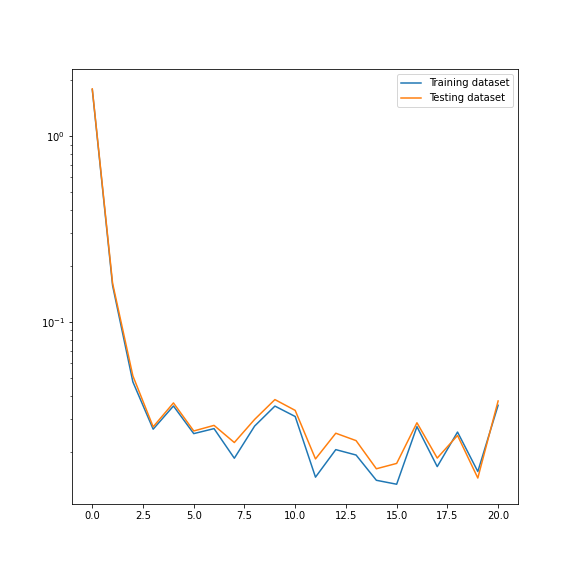

In [13]:
from IPython import display
display.Image("ml_out/test_last/loss_log.png")

Next we'll look at a plot of the bias, or any shift that the DNN has picked up relative to the true values. An unbiased result would be centred around 0. The plot below may have a _slight_ bias, but it could just be due to a lack of statistics.

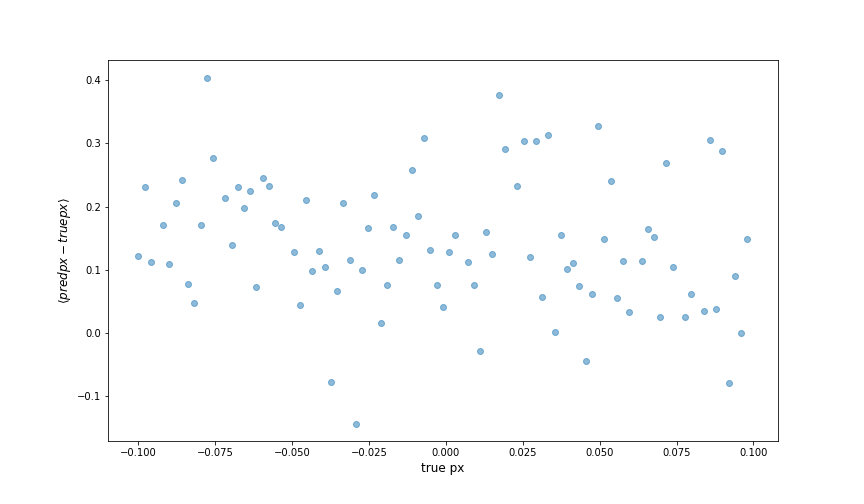

In [14]:
display.Image("ml_out/test_last/bias_px.png")

Let's look at a plot of the network's output as a function of the input. For this simple model we should expect this to be a linear plot with a slope of 1. We see the x, y, and z momenta, as well as the energy are all linear.

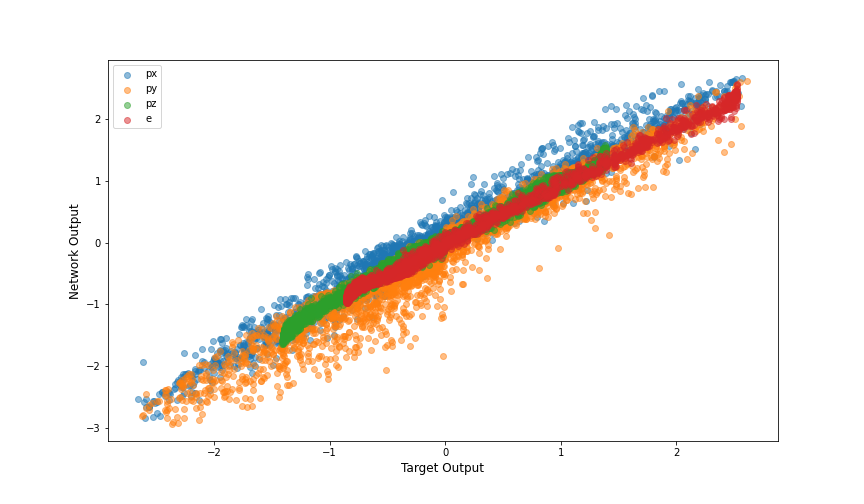

In [15]:
display.Image("ml_out/test_last/net_out.png")

We can also plot this as a heat map for e.g. the x momentum.

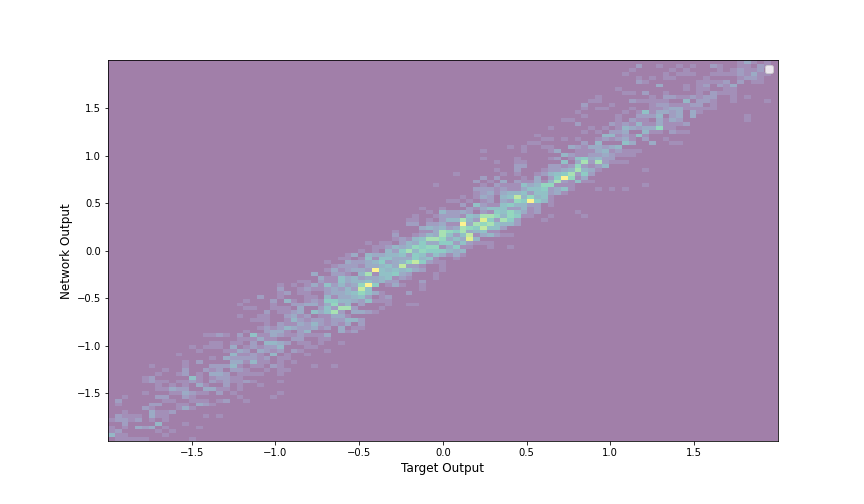

In [16]:
display.Image("ml_out/test_last/net_out_px2d.png")

In [17]:
# Constants (GeV)
W_MASS = 80.4
B_QUARK_MASS = 4.8
LEP_MASS = 0.105  # muon mass; can change to 0 for e or ~1.78 for τ
NU_MASS = 0.0

def isotropic_decay(top):
    """Generate an isotropic 3-body decay at rest."""
    # 1. Generate random directions
    theta = np.arccos(2 * np.random.rand(n) - 1)
    phi = 2 * np.pi * np.random.rand(n)
    
    # 2. Simplified: just do two-body W→ℓν, then top→b+W
    # In top rest frame
    E_b = np.ones(n) * (TOP_MASS**2 + B_QUARK_MASS**2 - W_MASS**2) / (2 * TOP_MASS)
    p_b = np.sqrt(E_b**2 - B_QUARK_MASS**2)

    E_W = TOP_MASS - E_b
    p_W = np.sqrt(E_W**2 - W_MASS**2)

    # W decay
    E_lep = np.ones(n) * (W_MASS**2 + LEP_MASS**2 - NU_MASS**2) / (2 * W_MASS)
    p_lep = np.sqrt(E_lep**2 - LEP_MASS**2)

    # Build vectors
    b = vector.arr({'px':p_b * np.sin(theta) * np.cos(phi),
                   'py':p_b * np.sin(theta) * np.sin(phi),
                   'pz':p_b * np.cos(theta),
                   'E':E_b})

    # Boost W decay to W frame then to top frame
    # Assume W and b back-to-back in top rest frame
    W = vector.arr({'px':-b.px, 'py':-b.py, 'pz':-b.pz, 'E':E_W})

    # Generate W decay in W rest frame
    theta2 = np.arccos(2 * np.random.rand(n) - 1)
    phi2 = 2 * np.pi * np.random.rand(n)

    lep = vector.arr({'px':p_lep * np.sin(theta2) * np.cos(phi2),
                     'py':p_lep * np.sin(theta2) * np.sin(phi2),
                     'pz':p_lep * np.cos(theta2),
                     'E':E_lep})
    nu = vector.arr({'px':-lep.px, 'py':-lep.py, 'pz':-lep.pz, 'E':E_W - E_lep})

    # Boost lep and nu to top rest frame
    lep_boosted = lep.boost(W)
    nu_boosted = nu.boost(W)

    return b, lep_boosted, nu_boosted

# Loop over tops and apply decay
#bs, leps, nus = [], [], []

#for top in tops:
# Decay in rest frame
b_rest, lep_rest, nu_rest = isotropic_decay(tops)

# Boost decay products to lab frame
b_lab = b_rest.boost(tops)
lep_lab = lep_rest.boost(tops)
nu_lab = nu_rest.boost(tops)

#bs.append(b_lab)
#leps.append(lep_lab)
#nus.append(nu_lab)

# Convert to awkward arrays
#bs = vector.arr(bs)
#leps = vector.arr(leps)
#nus = vector.arr(nus)

Since we can't detect neutrinos on the CMS experiment, we instead _infer_ their presence by taking the vector sum of all the transverse momenta. This sum _would_ be zero if we included the neutrinos, so we define a new quantity called the missing transverse momentum ($p_{\rm{T}}^{\rm{miss}}$ or MET) as the negative of the imbalance.

In [18]:
# Let's just use the neutrinos since we have them, but assigne their transverse momentum as MET
MET_px = nu_lab.px
MET_py = nu_lab.py

In [19]:
def save_top_decays():
    df = pd.DataFrame({
        "top_px": tops.px,
        "top_py": tops.py,
        "top_pz": tops.pz,
        "top_energy": tops.E,
        #"top_pt": tops.pt,
        #"top_eta": tops.eta,
        #"top_phi": tops.phi,
        #"top_mass": tops.mass,
        
        "b_px": b_lab.px,
        "b_py": b_lab.py,
        "b_pz": b_lab.pz,
        "b_energy": b_lab.E,

        "lep_px": lep_lab.px,
        "lep_py": lep_lab.py,
        "lep_pz": lep_lab.pz,
        "lep_energy": lep_lab.E,

        "MET_px": MET_px,
        "MET_py": MET_py
    })

    # Save to Parquet
    df.to_parquet("top_quarks.parquet")

In [20]:
save_top_decays()

In [21]:
tops = pd.read_parquet('top_quarks.parquet')
bins=np.linspace(0, 200, 50)
np.sqrt(tops['lep_px']**2 + tops['lep_py']**2).plot(kind='hist', 
                                                    label='lep pT', histtype="stepfilled", fc='none', edgecolor='b',
                                                    bins=bins)
np.sqrt(tops['b_px']**2 + tops['b_py']**2).plot(kind='hist', 
                                                label='b-jet pT', histtype="stepfilled", fc='none', edgecolor='orange',
                                                bins=bins)
np.sqrt(tops['top_px']**2 + tops['top_py']**2).plot(kind='hist', 
                                                    label='top pT', histtype="stepfilled", fc='none', edgecolor='red', 
                                                    bins=bins)
plt.legend()
plt.show()

Now we'll traing the DNN to reconstruct the top quarks 4-momentum using _only_ it's charged boosted decay products and the MET

In [22]:
main(features = 'top_x,top_y,top_z,top_energy,b_px,b_py,b_pz,b_energy,lep_px,lep_py,lep_pz,lep_energy,MET_px,MET_py', 
     feature_division = 4, 
     forceRebuild = True)

device='cuda'
['top_x', 'top_y', 'top_z', 'top_energy', 'b_px', 'b_py', 'b_pz', 'b_energy', 'lep_px', 'lep_py', 'lep_pz', 'lep_energy', 'MET_px', 'MET_py']
Fitting: ['b_px', 'b_py', 'b_pz', 'b_energy', 'lep_px', 'lep_py', 'lep_pz', 'lep_energy', 'MET_px', 'MET_py']
Will redo tensor with input features
Loading files, this may take a while


  0%|          | 0/1 [00:00<?, ?it/s]


Loading top_quarks.parquet


  0%|          | 0/20 [00:00<?, ?it/s]

Found 2.308852297200287% dead neurons!


No handles with labels found to put in legend.
/tmpscratch/byates2/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tmpscratch/byates2/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
100%|██████████| 20/20 [00:14<00:00,  1.35it/s]
No handles with labels found to put in legend.


Found 2.308852297200287% dead neurons!


The loss curve looks healthy

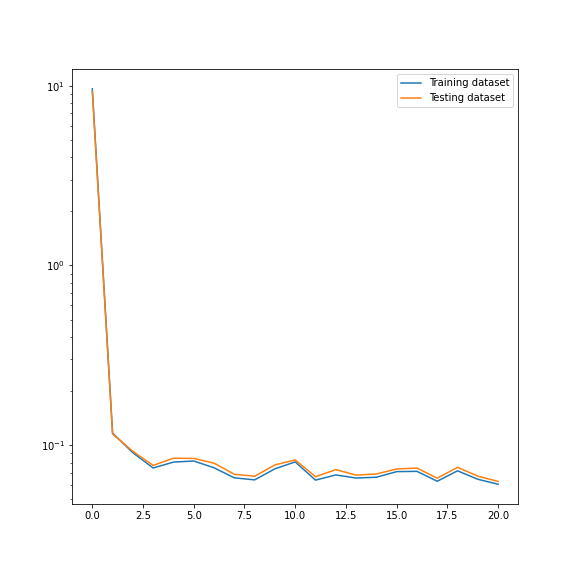

In [23]:
from IPython import display
display.Image("ml_out/test_last/loss_log.png")

And the output looks fairly linear with repspect to the input

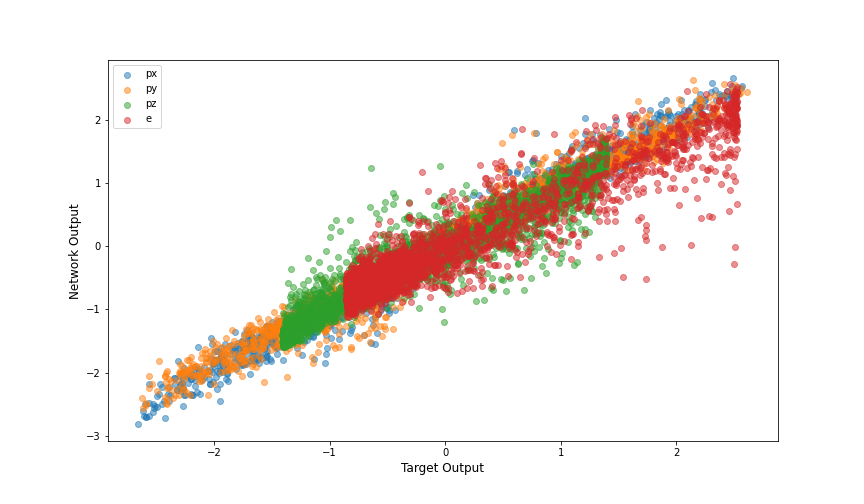

In [24]:
display.Image("ml_out/test_last/net_out.png")